In [107]:
from sklearn import ensemble, neighbors, svm, linear_model, model_selection, tree, metrics, preprocessing 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from itertools import product
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [108]:
def normalize_table(df):
    cols = list(df)
    for item in cols:
        if df[item].dtype == 'int64' or df[item].dtype == 'float64':
            max_tmp = np.max(np.array(df[item]))
            min_tmp = np.min(np.array(df[item]))
            if (max_tmp != min_tmp):
                df[item] = df[item].apply(
                    lambda x: (x - min_tmp) * 100 / (max_tmp - min_tmp))

In [109]:
def standardize_table(df):
    cols = list(df)
    for item in cols:
        if df[item].dtype == 'int64' or df[item].dtype == 'float64':
            mean_tmp = np.mean(np.array(df[item]))
            std_tmp = np.std(np.array(df[item]))
            if(std_tmp):
                df[item] = df[item].apply(lambda x: (x - mean_tmp) / std_tmp)

In [110]:
data = pd.read_csv("../tests/data/default/nginx.csv")
data_select = st.radio(
    """选择分析的数据集
    """,
    ('l3cache_stress.csv', 'nginx.csv'))
if data_select == 'l3cache_stress.csv':
    data = pd.read_csv("../tests/data/clickhouse/l3cache_stress.csv")
else:
    data=pd.read_csv("../tests/data/default/nginx.csv")
    data=data.drop(columns=['net','disk_io'])
mode = st.radio(
    "Please select a mode to visualize the data:",
    ('origin', 'normalization', 'standardization'))
standardize_table(data)
if mode == 'normalization':
    normalize_table(data)
elif mode == 'standardization':
    standardize_table(data)

In [111]:
print(data)
cluster_max=8
pca_predict=[]
for i in range(1,cluster_max):
    # kms=KMeans(n_clusters=i)
    # kms.fit(data.drop(columns='timestamp'))
    # data_predict.append(kms.predict(data.drop(columns='timestamp')))
    data_drop=data.drop(columns=['timestamp','qos'])
    pca=PCA(n_components=i)
    pca.fit(data_drop)
    pca_predict.append(pca.transform(data_drop))
    print(pca_predict)
    print(type(pca_predict))
    # print(data_predict)

               timestamp  context-switches  branch-misses  branch-load-misses  \
0    2022-03-09 08:29:01         -0.958754       1.678169            1.672848   
1    2022-03-09 08:29:11         -0.958754       1.511395            1.512181   
2    2022-03-09 08:29:21         -0.690142       1.742679            1.744449   
3    2022-03-09 08:29:31         -0.853227       1.534155            1.532438   
4    2022-03-09 08:29:41         -0.546243       1.611962            1.614179   
..                   ...               ...            ...                 ...   
613  2022-03-09 10:11:12         -1.198585       1.623724            1.624160   
614  2022-03-09 10:11:22         -0.191291       1.678942            1.678754   
615  2022-03-09 10:11:32         -1.083466       1.671203            1.671186   
616  2022-03-09 10:11:42         -1.083466       1.710989            1.712464   
617  2022-03-09 10:11:52         -1.006720       1.504206            1.503226   

          ipc  cpu-migratio

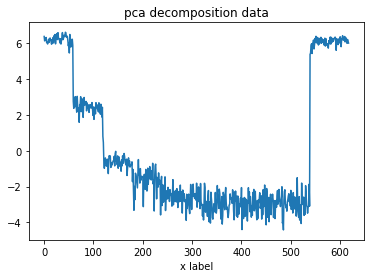

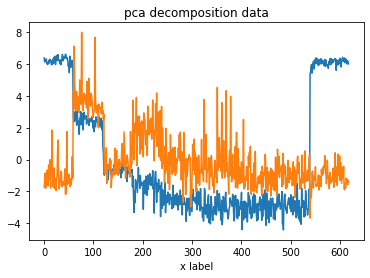

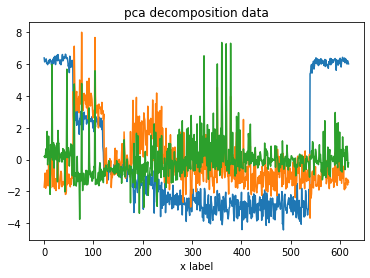

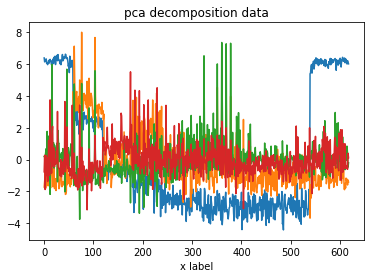

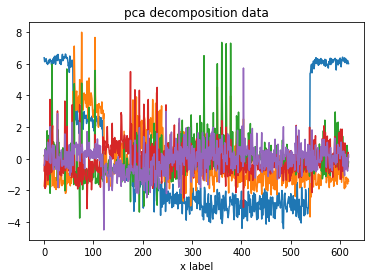

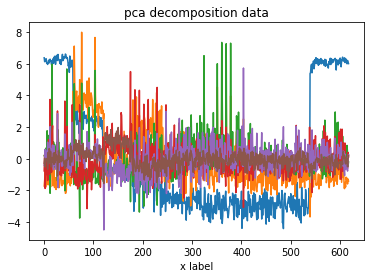

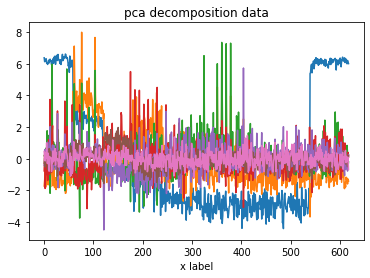

In [112]:
def plt_data(i):
    plt.xlabel('x label')
    plt.title('pca decomposition data')
    rev_data=pca_predict[i].T
    for i in range(len(rev_data)):
        plt.plot(rev_data[i])
    plt.show()
for i in range(1,cluster_max):
    plt_data(i-1)

In [113]:
class PolynomialRegressionModel():
    """polynomial regression model for metrics"""

    def __init__(self, degree,i) -> None:
        self.model = linear_model.LinearRegression()
        self.x = pca_predict[i-1]
        self.y = data[["qos"]]
        self.x_train, self.x_test, self.y_train, self.y_test = model_selection.train_test_split(self.x, self.y, random_state=1)
        self.mse = 0
        self.rmse = 0
        self.degree = degree

    def train_and_test_model(self):
        self.poly = preprocessing.PolynomialFeatures(degree = self.degree) 
        X_poly = self.poly.fit_transform(self.x_train)

        self.model.fit(X_poly, self.y_train)

        y_pred = self.model.predict(self.poly.transform(self.x_test))
        # score = model.score(x_test, y_test)
        # draw_comparison_altair_chart(y_test, y_pred)

        self.mse = metrics.mean_squared_error(self.y_test, y_pred)
        self.rmse = np.sqrt(metrics.mean_squared_error(self.y_test, y_pred))
        # model_evaluation = "MSE: {}, RMSE: {}".format(self.mse, self.rmse)
        # st.write(model_evaluation)


In [114]:
st.markdown("### 回归拟合分析")
# 数据预处理: 去除无效值; 特性缩放:标准化; 模型训练

def draw_comparison_altair_chart(y_test, y_pred):
    y_test_list = y_test["qos"]
    y_pred_list = y_pred if type(y_pred[0]) is not np.ndarray else [
        i[0] for i in y_pred]
    list_of_tuples = list(zip(y_test_list, y_pred_list))
    source = pd.DataFrame(list_of_tuples, columns=['Measured', 'Predicted'],
                          index=pd.RangeIndex(len(y_pred), name='index'))
    source = source.reset_index().melt('index', var_name='category', value_name='qos')
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['index'], empty='none')
    line = alt.Chart(source).mark_line(interpolate='basis').encode(
        x='index:Q',
        y='qos:Q',
        color='category:N'
    )

    selectors = alt.Chart(source).mark_point().encode(
        x='index:Q',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'qos:Q', alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart(source).mark_rule(color='gray').encode(
        x='index:Q',
    ).transform_filter(
        nearest
    )

    charts = alt.layer(
        line, selectors, points, rules, text
    ).interactive()
    st.altair_chart(charts, use_container_width=True)


In [115]:

class RegressionModel():
    """regression model for metrics"""

    def __init__(self, model,i) -> None:
        self.model = model
        self.mse = 0
        self.rmse = 0
        self.x = pca_predict[i-1]
        self.y = data[["qos"]]
        self.x_train, self.x_test, self.y_train, self.y_test = model_selection.train_test_split(self.x, self.y, random_state=1)
    def train_and_test_model(self):
        self.model.fit(self.x_train, np.ravel(self.y_train))

        y_pred = self.model.predict(self.x_test)
        # score = model.score(x_test, y_test)
        # draw_comparison_altair_chart(y_test, y_pred)

        self.mse = metrics.mean_squared_error(self.y_test, y_pred)
        self.rmse = np.sqrt(metrics.mean_squared_error(self.y_test, y_pred))
        # model_evaluation = "MSE: {}, RMSE: {}".format(self.mse, self.rmse)
        # st.write(model_evaluation)


In [116]:
polynomial_regression_list = [
    {'name': '1st Degree Polynomial Regression', 'degree': 1},
    {'name': '2nd Degree Polynomial Regression', 'degree': 2},
    {'name': '3rd Degree Polynomial Regression', 'degree': 3},
    {'name': '4th Degree Polynomial Regression', 'degree': 4},
    {'name': '5th Degree Polynomial Regression', 'degree': 5},
]

other_regression_list = [
    {'name': 'Decision Tree Regression', 'regressor': tree.DecisionTreeRegressor()},
    {'name': 'SVM Regression', 'regressor': svm.SVR()},
    {'name': 'KNN Regression', 'regressor': neighbors.KNeighborsRegressor()},
    {'name': 'Random Forest Regression', 'regressor': ensemble.RandomForestRegressor(n_estimators=20)},
    {'name': 'Adaboost Regression', 'regressor': ensemble.AdaBoostRegressor(n_estimators=50)},
    {'name': 'Gradient Boosting Regression', 'regressor': ensemble.GradientBoostingRegressor(n_estimators=100)},
    {'name': 'Bagging Regression', 'regressor': ensemble.BaggingRegressor()},
    {'name': 'ExtraTree Regression', 'regressor': tree.ExtraTreeRegressor()},
    {'name': 'ElasticNet','regressor':linear_model.ElasticNet()},
]




In [117]:
for i in range(1,cluster_max):
    mse_list = []
    polynomial_list = []
    st.write("### cluseter number :{}".format(i))
    for polynomial_regression in polynomial_regression_list:
        # st.markdown("#### " + polynomial_regression['name'])
        degree = polynomial_regression['degree']
        
        regression_model = PolynomialRegressionModel(degree,i)
        regression_model.train_and_test_model()

        polynomial_list.append({'name': polynomial_regression['name'], 'rmse': regression_model.rmse, 'regression_model': regression_model})
        mse_list.append({'name': polynomial_regression['name'], 'mse': regression_model.mse, 'rmse': regression_model.rmse})

    for other_regression in other_regression_list:
        # st.markdown("#### " + other_regression['name'])
        regressor = other_regression['regressor']
        
        regression_model = RegressionModel(regressor,i)
        regression_model.train_and_test_model()

        mse_list.append({'name': other_regression['name'], 'mse': regression_model.mse, 'rmse': regression_model.rmse})
    def takeMse(elem):
        return elem['rmse']
    mse_list.sort(key=takeMse)
    st.table(pd.DataFrame(mse_list).set_index('name'))